# Ice Optics Parameterization - Yi et al. 2013 (v1a)

Here, we are creating look-up-tables (LUT) for optical properties such as extinction coefficients, single scatter albedo $\omega_0$ and assymetry parameter $g$ for ice cloud parameter ranges used in Test 1 (Altitude/Temperature):

* Ice Mass Mixing ratio $q_i$ $\left[\frac{\text{kg of ice}}{\text{kg of air}}\right]$ range: 

$$q_i = \left(\text{0.04 to 0.11} \; \left[\frac{\text{g of ice}}{\text{kg of air}}\right]\right) \; \times \; 0.001 \; \left[\frac{\text{kg of ice}}{\text{g of ice}}\right]$$

* Ice Water Content IWC ($g$ $m^{-3}$) (We're using an average density of 0.3 $kg$ $m^{-3}$ between 10 km and 15 km):

$$IWC = q_i \left[\frac{\text{kg of ice}}{\text{kg of air}}\right] * 1000 \left[\frac{\text{g of ice}}{\text{kg of ice}}\right] * 0.3 \left[\frac{\text{kg of air}}{m^3}\right]$$

* Ice Water Path IWP ($g/m^2$) range: 0.1 to 300.1 $g/m^2$

* Fixed Effective Radius $r_e (\mu m)$ (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Reading scheme

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'yi_ice_scattering_rrtm.nc'
#fu_scatt  = xr.open_dataset(data_path+file, drop_variables='siglay')
yi_scatt = nc.Dataset(data_path+file)

In [3]:
yi_scatt

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): band_sw(14), band_lw(16), coeff_sw(69), coeff_lw(69)
    variables(dimensions): float32 wavenumber1_sw(band_sw), float32 wavenumber2_sw(band_sw), float32 wavenumber1_lw(band_lw), float32 wavenumber2_lw(band_lw), float32 coeff_sw(band_sw, coeff_sw), float32 coeff_lw(band_lw, coeff_lw)
    groups: 

In [4]:
# SHORTWAVE
# Lower bound wavenumber (cm-1) for shortwave band. See Yi et al., 2013.
yi_sw_wn1 = yi_scatt.variables['wavenumber1_sw'][:]
yi_sw_wl1 = 1e4 / yi_sw_wn1 # (um)

# Upper bound wavenumber (cm-1) for shortwave band. See Yi et al., 2013.
yi_sw_wn2 = yi_scatt.variables['wavenumber2_sw'][:]
yi_sw_wl2 = 1e4 / yi_sw_wn2 # (um)

# Shorwave Coefficients (10 coefficients in total (See Yi et al., 2013.)):
yi_sw_coeff = yi_scatt.variables['coeff_sw'][:]


# LONGWAVE
# Lower bound wavenumber (cm-1) for longwave band.
yi_lw_wn1 = yi_scatt.variables['wavenumber1_lw'][:]
yi_lw_wl1 = 1e4 / yi_lw_wn1 # (um)

# Upper bound wavenumber (cm-1) for longwave band.
yi_lw_wn2 = yi_scatt.variables['wavenumber2_lw'][:]
yi_lw_wl2 = 1e4 / yi_lw_wn2 # (um)

# Longwave Coefficients:
yi_lw_coeff = yi_scatt.variables['coeff_lw'][:]

14 SW bands and 69 coefficients. Coefficient matrix is 14 X 69

## Computing Optical Properties (Shortwave)

Check Fortran code from Hogan (radiation_ice_optics_yi.F90):

In [5]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001

# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3

# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)

# Effective Diameter (um)
D_e = r_e * 2 # See definition of de_um in radiation_ice_optics_yi.F90

# LUT variables (see radiation_ice_optics_yi.F90):
lu_scale  = 0.2
lu_offset = 1

NSingleCoeffs = 23


# Extinction Coefficients (m-1)
yi_sw_b_ext = np.zeros((len(yi_sw_wn1), len(D_e), len(q_i)))
# Mass Extinction Coefficients (m2/g)
yi_sw_K_ext = np.zeros((len(yi_sw_wn1), len(D_e), len(q_i)))
# Mass Absorption Coefficients (m2/g)
yi_sw_K_abs = np.zeros((len(yi_sw_wn1), len(D_e), len(q_i)))

# Single Scatter Albedo:
yi_sw_ssa   = np.zeros((len(yi_sw_wn1), len(D_e), len(q_i)))

# Asymmetry Factor:
yi_sw_g     = np.zeros((len(yi_sw_wn1), len(D_e), len(q_i)))

for wn_ix in range(len(yi_sw_wn1)):
    for d_ix in range(len(D_e)):
        d_i    = D_e[d_ix]
        lu_idx = math.floor(d_i * lu_scale - lu_offset)
        wts2   = (d_i * lu_scale - lu_offset) - lu_idx
        wts1   = 1 - wts2
        for iwc_ix in range(len(iwc)):
            iwc_i   = iwc[iwc_ix] # g m-3
            # Following Hogan equations in "radiation_ice_optics_yi.F90":
            # Extinction Coefficients (m-1):
            b_ext_i = iwc_i * (wts1 * yi_sw_coeff[wn_ix, lu_idx - 1] + wts2 * yi_sw_coeff[wn_ix, lu_idx]) 
            yi_sw_b_ext[wn_ix, d_ix, iwc_ix] = b_ext_i * 0.001 # Transform Kext from m2/kg to m2/g
            
            # Mass Extinction Coefficients (m2/g):
            K_ext_i = wts1 * yi_sw_coeff[wn_ix, lu_idx - 1] + wts2 * yi_sw_coeff[wn_ix, lu_idx]
            yi_sw_K_ext[wn_ix, d_ix, iwc_ix] = K_ext_i * 0.001 # Transform from m2/kg to m2/g
            
            # Single Scattering Albedo w:
            ssa_i   = wts1 * yi_sw_coeff[wn_ix, lu_idx - 1 + NSingleCoeffs] + wts2 * yi_sw_coeff[wn_ix, lu_idx + NSingleCoeffs]
            yi_sw_ssa[wn_ix, d_ix, iwc_ix] = ssa_i
            
            # Mass Absorption Coefficients (m2/g):
            K_abs_i = K_ext_i*(1 - ssa_i)
            yi_sw_K_abs[wn_ix, d_ix, iwc_ix] = K_abs_i * 0.001 # Transform from m2/kg to m2/g
            
            # Asymmetry Parameter g:
            g_i = wts1 * yi_sw_coeff[wn_ix, lu_idx - 1 + 2 * NSingleCoeffs] + wts2 * yi_sw_coeff[wn_ix, lu_idx + 2 * NSingleCoeffs]
            yi_sw_g[wn_ix, d_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Yi SW

In [6]:
yi_sw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'd_e', 'iwc'], yi_sw_K_ext),
        K_abs = (['sw_wn_1', 'd_e', 'iwc'], yi_sw_K_abs),
        ssa = (['sw_wn_1', 'd_e', 'iwc'], yi_sw_ssa),
        g = (['sw_wn_1', 'd_e', 'iwc'], yi_sw_g),
    ),
    attrs = dict(
        title="LUT for Yi SW. Ranges for Altitude-Temperature Test."),
)

In [7]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'YiSW_test1_LUT_v1a.nc'
yi_sw.to_netcdf(path = out_dir+file)

## Computing optical properties (Longwave)

In [7]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001

# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3

# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)

# Effective Diameter (um)
D_e = r_e * 2 # See definition of de_um in radiation_ice_optics_yi.F90

# LUT variables (see radiation_ice_optics_yi.F90):
lu_scale  = 0.2
lu_offset = 1

NSingleCoeffs = 23

# For LONGWAVE:
# Extinction Coefficients (m-1)
yi_lw_b_ext = np.zeros((len(yi_lw_wn1), len(D_e), len(q_i)))
# Mass Extinction Coefficients (m2/g)
yi_lw_K_ext = np.zeros((len(yi_lw_wn1), len(D_e), len(q_i)))
# Mass Absorption Coefficients (m2/g)
yi_lw_K_abs = np.zeros((len(yi_lw_wn1), len(D_e), len(q_i)))

# Single Scatter Albedo:
yi_lw_ssa   = np.zeros((len(yi_lw_wn1), len(D_e), len(q_i)))

# Asymmetry Factor:
yi_lw_g     = np.zeros((len(yi_lw_wn1), len(D_e), len(q_i)))

for wn_ix in range(len(yi_lw_wn1)):
    for d_ix in range(len(D_e)):
        d_i    = D_e[d_ix]
        lu_idx = math.floor(d_i * lu_scale - lu_offset)
        wts2   = (d_i * lu_scale - lu_offset) - lu_idx
        wts1   = 1 - wts2
        for iwc_ix in range(len(iwc)):
            iwc_i   = iwc[iwc_ix]
            # Following Hogan equations in "radiation_ice_optics_yi.F90":
            # Extinction Coefficients (m-1):
            b_ext_i = iwc_i * (wts1 * yi_lw_coeff[wn_ix, lu_idx - 1] + wts2 * yi_lw_coeff[wn_ix, lu_idx]) 
            yi_lw_b_ext[wn_ix, d_ix, iwc_ix] = b_ext_i * 0.001 # Transform Kext from m2/kg to m2/g
            
            # Mass Extinction Coefficients (m2/g):
            K_ext_i = wts1 * yi_lw_coeff[wn_ix, lu_idx - 1] + wts2 * yi_lw_coeff[wn_ix, lu_idx]
            yi_lw_K_ext[wn_ix, d_ix, iwc_ix] = K_ext_i * 0.001 # Transform from m2/kg to m2/g

            # Single Scattering Albedo w:
            ssa_i = wts1 * yi_lw_coeff[wn_ix, lu_idx - 1 + NSingleCoeffs] + wts2 * yi_lw_coeff[wn_ix, lu_idx + NSingleCoeffs]
            yi_lw_ssa[wn_ix, d_ix, iwc_ix] = ssa_i

            # Mass Absorption Coefficients (m2/g):
            K_abs_i = K_ext_i*(1 - ssa_i)
            yi_lw_K_abs[wn_ix, d_ix, iwc_ix] = K_abs_i * 0.001 # Transform from m2/kg to m2/g
            
            # Asymmetry Parameter g:
            g_i     = wts1 * yi_lw_coeff[wn_ix, lu_idx - 1 + 2 * NSingleCoeffs] + wts2 * yi_lw_coeff[wn_ix, lu_idx + 2 * NSingleCoeffs]
            yi_lw_g[wn_ix, d_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Yi LW

In [8]:
yi_lw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'd_e', 'iwc'], yi_lw_K_ext),
        K_abs = (['sw_wn_1', 'd_e', 'iwc'], yi_lw_K_abs),
        ssa = (['sw_wn_1', 'd_e', 'iwc'], yi_lw_ssa),
        g = (['sw_wn_1', 'd_e', 'iwc'], yi_lw_g),
    ),
    attrs = dict(
        title="LUT for Yi LW. Ranges for Altitude-Temperature Test."),
)

In [10]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'YiLW_test1_LUT_v1a.nc'
yi_lw.to_netcdf(path = out_dir + file)

## Plotting optical parameters vs particle size and wavelength

<IPython.core.display.Javascript object>


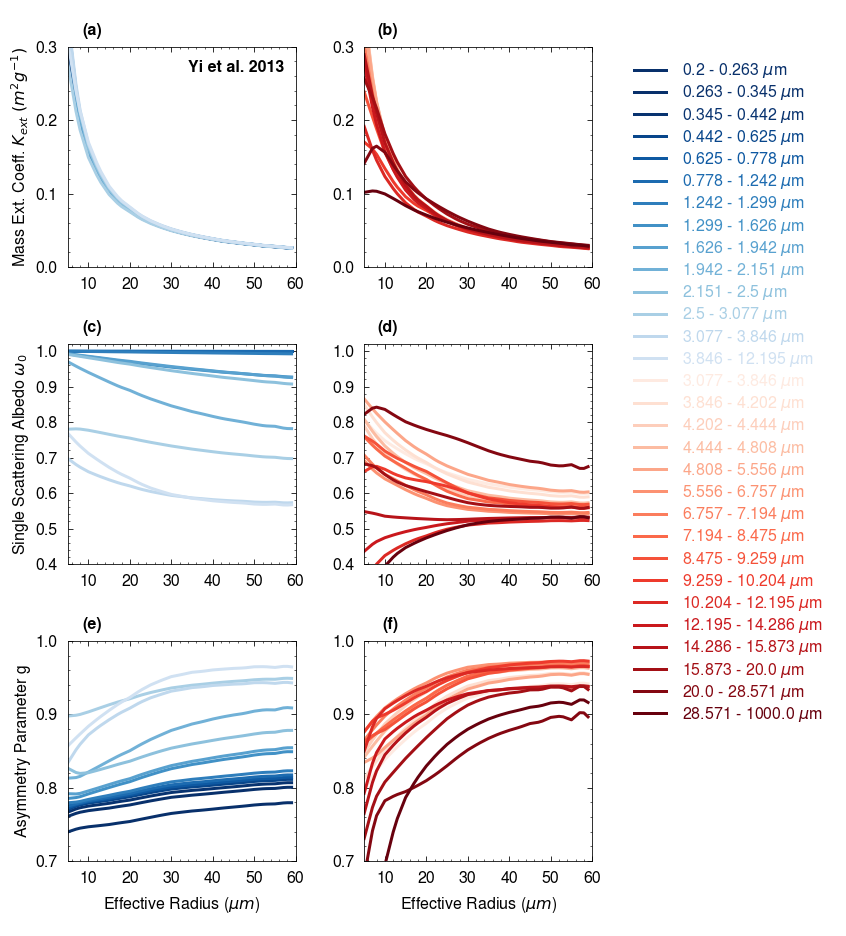

In [11]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13 # inches
flength  = 11.75 # inches


rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.08, right = 0.7, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        yi_plot = eval('yi_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) + [13] # Selected bands len(yi_plot[:,0,0])
        if rad_comp == 1: bands = list(np.arange(0,16)[::-1]) # Selected bands len(yi_plot[:,0,0])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(r_e, yi_plot[band, :, 0],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn1')[band],3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('yi_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('yi_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)
               
        # X Axis:
        if opt_prop == 2:
            ax[opt_prop, rad_comp].set_xlabel(r'Effective Radius ($\mu m$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(5, 60)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
#                                            size = 5, direction = 'in', top = True,
#                                            labelsize = fontsize, pad = 10)
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'minor', color = 'black', 
#                                            size = 2, direction = 'in', top = True, 
#                                            labelsize = fontsize1, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        

        
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
        if opt_prop == 0: # Mass Extinction Coefficient
            ax[opt_prop, rad_comp].set_ylim(0, 0.3)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 1: # SSA
            ax[opt_prop, rad_comp].set_ylim(0.4, 1.02)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 2: # g
            ax[opt_prop, rad_comp].set_ylim(0.7, 1)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
        
# Scheme Title:
ax[0, 0].text(0.95, 0.94, 'Yi et al. 2013', weight = 'bold',
              ha = 'right', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.99, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_opt_prop_all_bands_yi_full_size_v1a.png', dpi=500)

Plot optical parameters vs wavelength for one size (30 um)

<IPython.core.display.Javascript object>


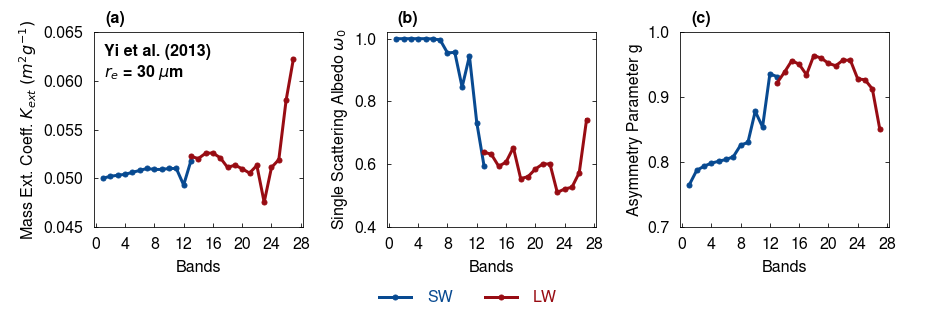

In [12]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 4.5 # inches
flength  = 13 # inches


rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.3, left = 0.1, right = 0.95, 
                    hspace = .35, wspace = .4)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

sel_size = np.where(r_e == 30)[0][0] # 30 um selected

for opt_prop in range(columns):
    yi_sw_plot = eval('yi_sw_' + opt_props[opt_prop])
    yi_lw_plot = eval('yi_lw_' + opt_props[opt_prop])
    h1 = ax[opt_prop].plot(np.arange(1,14),yi_sw_plot[:-1, sel_size, 0][::-1],
                           '.-',#linestyle = 'solid', 
                           markersize = 10,
                           linewidth = 3, color = matplotlib.cm.Blues(.9))
    h2 = ax[opt_prop].plot(np.arange(13,28),yi_lw_plot[1:, sel_size, 0][::-1],
                           '.-',#linestyle = 'solid', 
                           markersize = 10,
                           linewidth = 3, color = matplotlib.cm.Reds(.9))

    ax[opt_prop].set_xlabel('Bands', fontsize = fontsize, fontname = fontname,
                            color ='black', labelpad = 7.5)
    for tick in ax[opt_prop].get_xticklabels():
        tick.set_fontname(fontname)
    ax[opt_prop].xaxis.set_major_locator(ticker.MultipleLocator(4))

    for tick in ax[opt_prop].get_yticklabels():
        tick.set_fontname(fontname)
    opt_props_labeli = opt_props_label[opt_prop]
    ax[opt_prop].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                          fontname = fontname, color ='black', labelpad = 5)
    if opt_prop == 0: # Mass Extinction Coefficient
        ax[opt_prop].set_ylim(0.045, 0.065)
    elif opt_prop == 1: # SSA
        ax[opt_prop].set_ylim(0.4, 1.02)
    elif opt_prop == 2: # g
        ax[opt_prop].set_ylim(0.7, 1)
    
    ax[opt_prop].tick_params(axis = 'both', which = 'major', color = 'black',
                             size = 4, direction = 'in', right = True,
                             labelsize = fontsize, pad = 10)
    
    # Panel letters:
    ax[opt_prop].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                ha = 'right', va = 'top', transform = ax[opt_prop].transAxes,
                                fontsize = fontsize, fontname = fontname, color = 'black')
    panel_letters_i += 1

ax[0].text(0.05, 0.94, r'Yi et al. (2013)' + '\n' + '$r_e$ = 30 $\mu$m', weight = 'bold',
           ha = 'left', va = 'top', transform = ax[0].transAxes,
           fontsize = fontsize, fontname = fontname, color = 'black')
    
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2
labels  = ['SW', 'LW']
legend  = plt.legend(handles, labels, loc = 'lower center',
                     bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 2, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_opt_prop_vs_bands_30um_v1a.png', dpi=500)

## Comparing Yi and Fu

In [10]:
in_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
fu_sw  = xr.open_dataset(in_dir+'FuSW_test1_LUT_v1a.nc')
fu_lw  = xr.open_dataset(in_dir+'FuLW_test1_LUT_v1a.nc')

Computting differences:

In [11]:
rad_comps = ['sw','lw']
opt_props = ['K_ext', 'K_abs', 'ssa', 'g']
for rad_comp in range(len(rad_comps)):
    for opt_prop in range(len(opt_props)):
        yi_case = eval('yi_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        fu_case = eval('fu_'+rad_comps[rad_comp])[opt_props[opt_prop]].values
        globals()['comp_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop]] = yi_case - fu_case

<IPython.core.display.Javascript object>


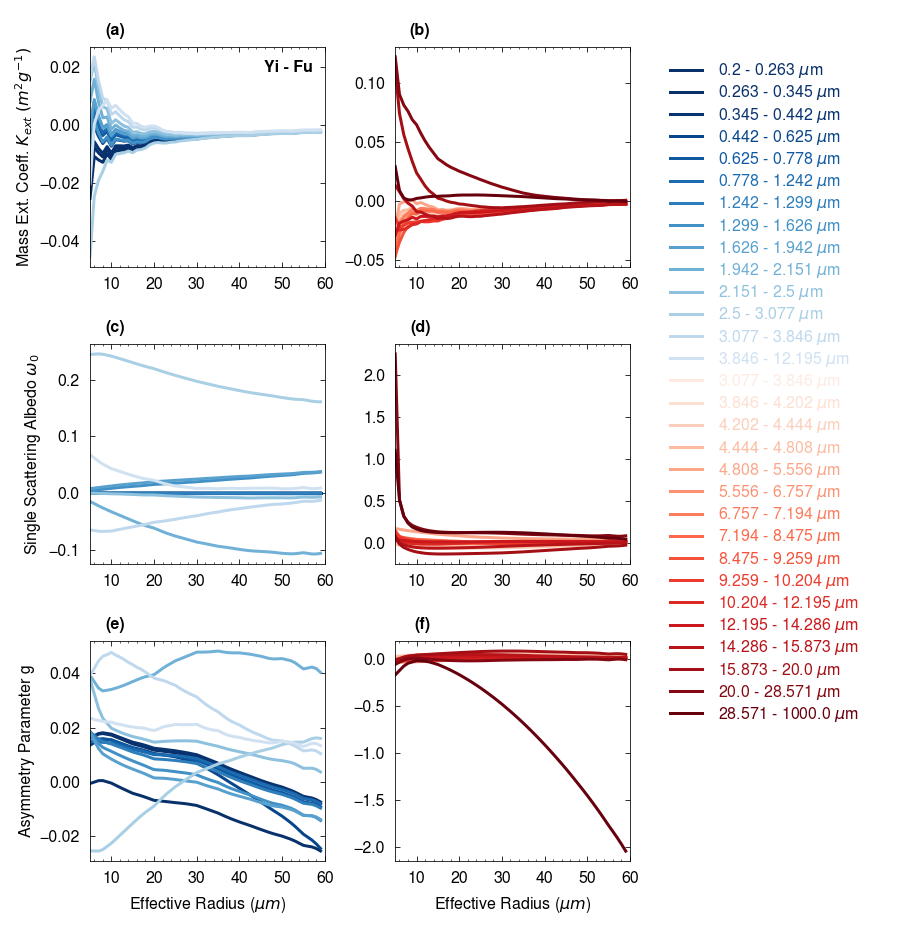

In [15]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13 # inches
flength  = 12.5 # inches


rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.7, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 'Asymmetry Parameter g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        diff_plot = eval('comp_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) + [13] # Selected bands len(yi_plot[:,0,0])
        if rad_comp == 1: bands = list(np.arange(0,16)[::-1]) # Selected bands len(yi_plot[:,0,0])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(r_e, diff_plot[band, :, 0],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn1')[band],3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('yi_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('yi_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)
               
        # X Axis:
        if opt_prop == 2:
            ax[opt_prop, rad_comp].set_xlabel(r'Effective Radius ($\mu m$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(5, 60)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
#                                            size = 5, direction = 'in', top = True,
#                                            labelsize = fontsize, pad = 10)
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'minor', color = 'black', 
#                                            size = 2, direction = 'in', top = True, 
#                                            labelsize = fontsize1, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        

        
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
#         if opt_prop == 0: # Mass Extinction Coefficient
#             ax[opt_prop, rad_comp].set_ylim(-0.05, 0.2)
#             ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.05))
#             ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.01))
#         elif opt_prop == 1: # SSA
#             ax[opt_prop, rad_comp].set_ylim(-0.15, 1.02)
#             ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
#             ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
#         elif opt_prop == 2: # g
#             ax[opt_prop, rad_comp].set_ylim(0.7, 1)
#             ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
#             ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
#         # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
        
# Scheme Title:
ax[0, 0].text(0.95, 0.94, 'Yi - Fu', weight = 'bold',
              ha = 'right', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.97, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_fu_comp_prop_all_bands_full_size_v1a.png', dpi=500)

Check this with Zhao et al. 2018 (https://www.sciencedirect.com/science/article/pii/S0169809517309122?via%3Dihub)

Selected bands (from Fu figures):

<IPython.core.display.Javascript object>


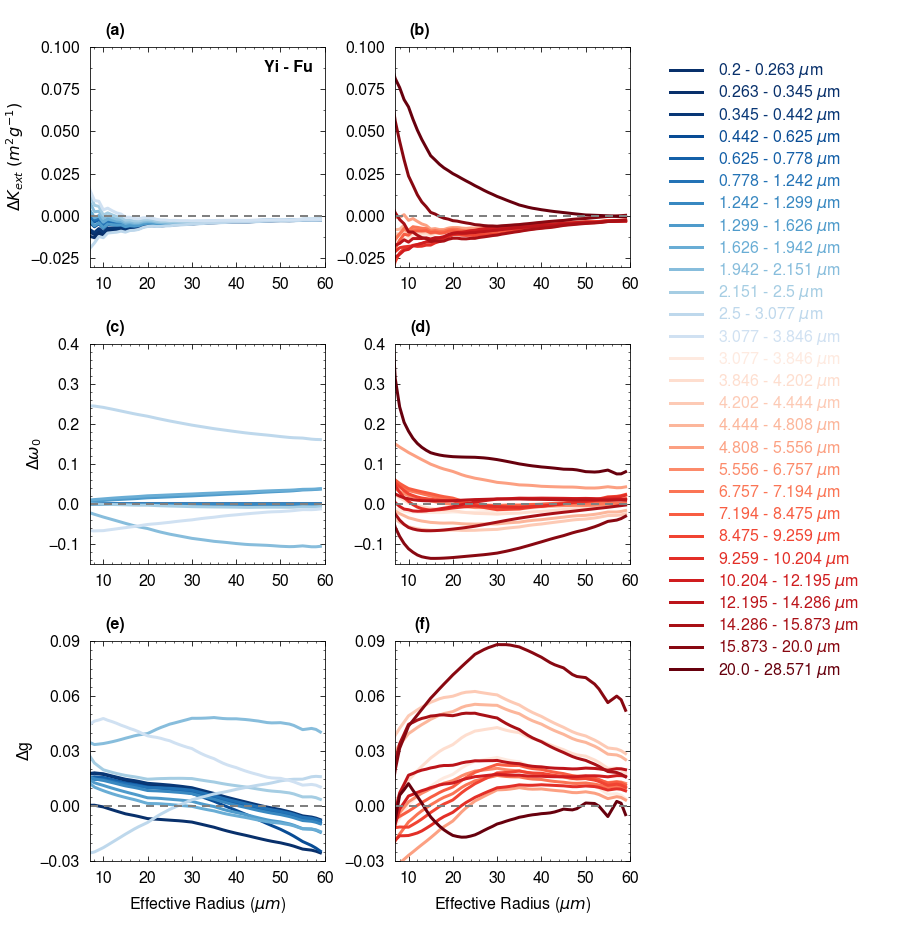

In [16]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13 # inches
flength  = 12.5 # inches


rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.7, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw','lw']
opt_props       = ['K_ext', 'ssa', 'g']
opt_props_label = [r'$\Delta K_{ext}$ $(m^2g^{-1})$', r'$\Delta \omega_0$', r'$\Delta$g']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        diff_plot = eval('comp_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) # Selected bands len(fu_plot[:,0,0])
        if rad_comp == 1: bands = list(np.arange(1,16)[::-1]) # Selected bands len(fu_plot[:,0,0])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(r_e, diff_plot[band, :, 0],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            hline = ax[opt_prop, rad_comp].axhline(y = 0, dashes = [4, 3], color = 'grey', linewidth = 2)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('yi_'+rad_comps[rad_comp]+'_wn1')[band],3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('yi_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('yi_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)
               
        # X Axis:
        if opt_prop == 2:
            ax[opt_prop, rad_comp].set_xlabel(r'Effective Radius ($\mu m$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(7, 60)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
#                                            size = 5, direction = 'in', top = True,
#                                            labelsize = fontsize, pad = 10)
#         ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'minor', color = 'black', 
#                                            size = 2, direction = 'in', top = True, 
#                                            labelsize = fontsize1, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        

        
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
        if opt_prop == 0: # Mass Extinction Coefficient
            ax[opt_prop, rad_comp].set_ylim(-0.03, 0.1)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.025))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.0125))
        elif opt_prop == 1: # SSA
            ax[opt_prop, rad_comp].set_ylim(-0.15, 0.4)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 2: # g
            ax[opt_prop, rad_comp].set_ylim(-0.03, 0.09)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.03))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.005))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
        
# Scheme Title:
ax[0, 0].text(0.95, 0.94, 'Yi - Fu', weight = 'bold',
              ha = 'right', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.97, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_fu_comp_prop_sel_bands_sel_size_v1a.png', dpi=500)

### Figure S# - SW: Fu, Yi, Yi-Fu

<IPython.core.display.Javascript object>


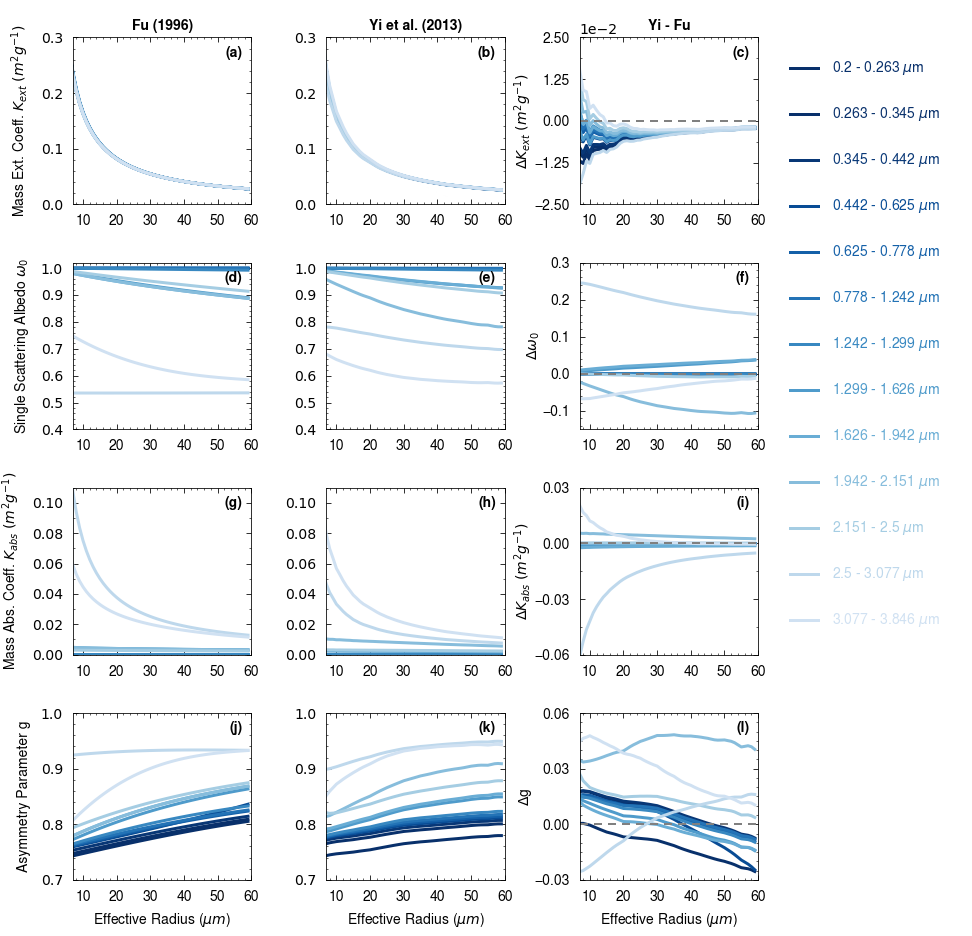

In [11]:
fontname = 'Nimbus Sans' # Arial
fontsize = 14
fheigth  = 13 # inches
flength  = 13.5 # inches


rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.96, bottom = 0.06, left = 0.075, right = 0.78, 
                    hspace = .35, wspace = .42)


schemes          = ['fu', 'yi', 'comp']
schemes_titles   = ['Fu (1996)', 'Yi et al. (2013)', 'Yi - Fu']
opt_props        = ['K_ext', 'ssa', 'K_abs', 'g']
diff_props_label = [r'$\Delta K_{ext}$ $(m^2g^{-1})$', r'$\Delta \omega_0$', r'$\Delta K_{abs}$ $(m^2g^{-1})$', r'$\Delta$g']
opt_props_label  = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$',
                    r'Mass Abs. Coeff. $K_{abs}$ $(m^2g^{-1})$', 'Asymmetry Parameter g']
panel_letters    = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
panel_letters_i  = 0

for opt_prop in range(rows):
    for scheme in range(columns):
        handles = []
        labels  = []
        if scheme == 0: curves_to_plot = eval(schemes[scheme] + '_sw')[opt_props[opt_prop]].values
        else: curves_to_plot = eval(schemes[scheme] + '_sw_' + opt_props[opt_prop])
        bands = list(np.arange(0,13)[::-1]) # Selected bands from Fu
        for band in bands:
            color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            h = ax[opt_prop, scheme].plot(r_e, curves_to_plot[band, :, 0],
                                          linestyle = 'solid', 
                                          linewidth = 3, color = color)
            if scheme == 2:
                hline = ax[opt_prop, scheme].axhline(y = 0, dashes = [4, 3], color = 'grey', linewidth = 2)
            label = (str(round(1e4/eval('yi_sw_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('yi_sw_wn1')[band],3)) + r' $\mu$m')
            handles = handles + h
            labels.append(label)
               
        # X Axis:
        if opt_prop == 3:
            ax[opt_prop, scheme].set_xlabel(r'Effective Radius ($\mu m$)', 
                                            fontsize = fontsize, fontname = fontname,
                                            color ='black', labelpad = 7.5)
        ax[opt_prop, scheme].set_xlim(7, 60)
        ax[opt_prop, scheme].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, scheme].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        for tick in ax[opt_prop, scheme].get_xticklabels():
            tick.set_fontname(fontname)
        
        # Y Axis:
        opt_props_labeli  = opt_props_label[opt_prop]
        diff_props_labeli = diff_props_label[opt_prop]
        if scheme == 0:
            ax[opt_prop, scheme].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                            fontname = fontname, color ='black', labelpad = 10)
        elif scheme == 2:
            ax[opt_prop, scheme].set_ylabel(diff_props_labeli, fontsize = fontsize, 
                                            fontname = fontname, color ='black', labelpad = 0)
        ax[opt_prop, scheme].yaxis.get_offset_text().set_fontsize(fontsize)
            
        if scheme in [0, 1]:
            if opt_prop == 0: # Mass Extinction Coefficient
                ax[opt_prop, scheme].set_ylim(0, 0.3)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 1: # SSA
                ax[opt_prop, scheme].set_ylim(0.4, 1.02)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 2: # Mass Absorption Coefficient
                ax[opt_prop, scheme].set_ylim(0, 0.11)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.02))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.01))
            elif opt_prop == 3: # g
                ax[opt_prop, scheme].set_ylim(0.7, 1)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        else:
            if opt_prop == 0: # Mass Extinction Coefficient
                ax[opt_prop, scheme].set_ylim(-0.025, 0.025)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.0125))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.00625))
                # Set the y-axis tick labels to scientific notation:
                ax[opt_prop, scheme].ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 2))
            elif opt_prop == 1: # SSA
                ax[opt_prop, scheme].set_ylim(-0.15, 0.3)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 2: # Absorption Extinction Coefficient
                ax[opt_prop, scheme].set_ylim(-0.06, 0.03)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.03))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.015))
            elif opt_prop == 3: # g
                ax[opt_prop, scheme].set_ylim(-0.03, 0.06)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.03))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.005))
            # ax[opt_prop, scheme].locator_params(axis = 'x', nbins = 6) 
            for tick in ax[opt_prop, scheme].get_yticklabels():
                tick.set_fontname(fontname)
            
        # Both axis:
        ax[opt_prop, scheme].tick_params(axis = 'both', which = 'major', color = 'black',
                                         size = 5, direction = 'in', top = True, right = True,
                                         labelsize = fontsize, pad = 10)
        ax[opt_prop, scheme].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                         size = 2, direction = 'in', top = True, right = True,
                                         labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, scheme].text(0.95, 0.95, panel_letters[panel_letters_i], weight = 'bold',
                                  ha = 'right', va = 'top', transform = ax[opt_prop, scheme].transAxes,
                                  fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        # Scheme Title:
        if opt_prop == 0:
            ax[opt_prop, scheme].text(0.5, 1.11, schemes_titles[scheme], weight = 'bold',
                                      ha = 'center', va = 'top', transform = ax[opt_prop, scheme].transAxes,
                                      fontsize = fontsize, fontname = fontname, color = 'black')

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.98, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = 2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_fu_comp_prop_SW_sel_bands_sel_size_v1a_SM.png', dpi=500)

### Figure S# - LW: Fu, Yi, Yi-Fu

<IPython.core.display.Javascript object>


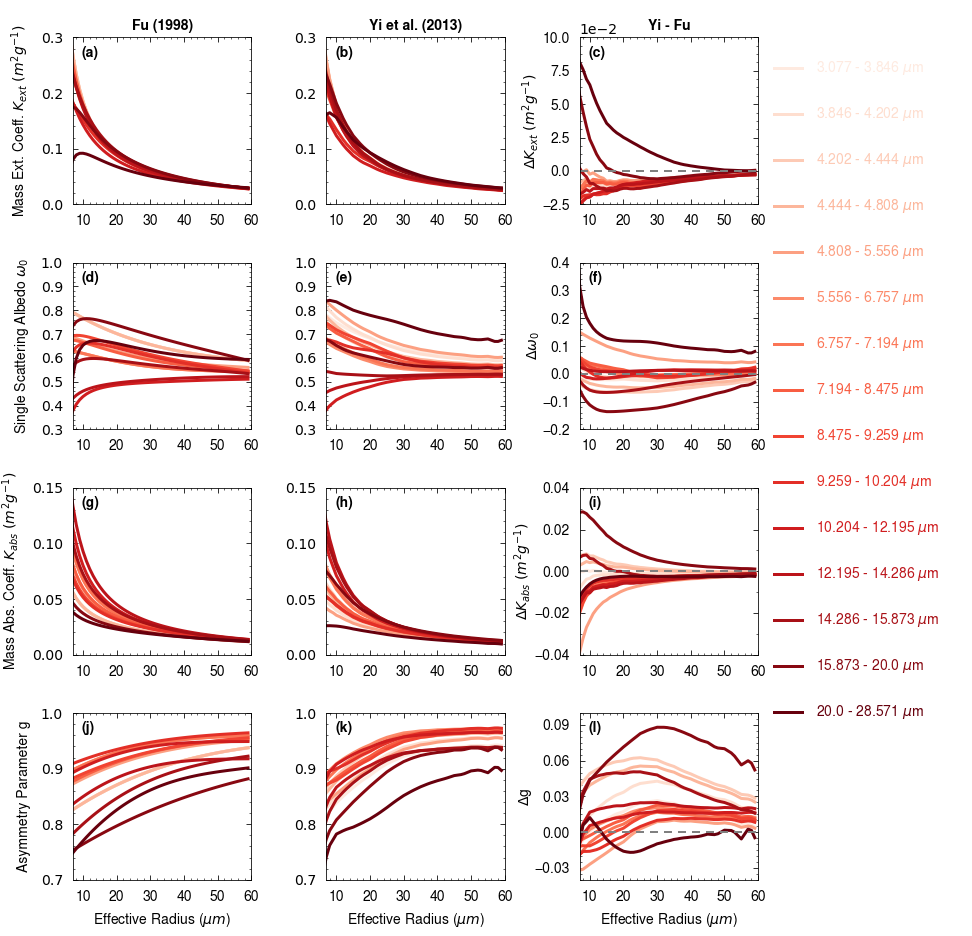

In [25]:
fontname = 'Nimbus Sans' # Arial
fontsize = 14
fheigth  = 13 # inches
flength  = 13.5 # inches


rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.96, bottom = 0.06, left = 0.075, right = 0.78, 
                    hspace = .35, wspace = .42)


schemes          = ['fu', 'yi', 'comp']
schemes_titles   = ['Fu (1998)', 'Yi et al. (2013)', 'Yi - Fu']
opt_props        = ['K_ext', 'ssa', 'K_abs', 'g']
diff_props_label = [r'$\Delta K_{ext}$ $(m^2g^{-1})$', r'$\Delta \omega_0$', r'$\Delta K_{abs}$ $(m^2g^{-1})$', r'$\Delta$g']
opt_props_label  = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$',
                    r'Mass Abs. Coeff. $K_{abs}$ $(m^2g^{-1})$', 'Asymmetry Parameter g']
panel_letters    = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
panel_letters_i  = 0

for opt_prop in range(rows):
    for scheme in range(columns):
        handles = []
        labels  = []
        if scheme == 0: curves_to_plot = eval(schemes[scheme] + '_lw')[opt_props[opt_prop]].values
        else: curves_to_plot = eval(schemes[scheme] + '_lw_' + opt_props[opt_prop])
        bands = list(np.arange(1,16)[::-1]) # Selected bands from Fu
        for band in bands:
            color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, scheme].plot(r_e, curves_to_plot[band, :, 0],
                                          linestyle = 'solid', 
                                          linewidth = 3, color = color)
            if scheme == 2:
                hline = ax[opt_prop, scheme].axhline(y = 0, dashes = [4, 3], color = 'grey', linewidth = 2)
            label = (str(round(1e4/eval('yi_lw_wn2')[band],3)) + ' - ' +  
                     str(round(1e4/eval('yi_lw_wn1')[band],3)) + r' $\mu$m')
            handles = handles + h
            labels.append(label)
               
        # X Axis:
        if opt_prop == 3:
            ax[opt_prop, scheme].set_xlabel(r'Effective Radius ($\mu m$)', 
                                            fontsize = fontsize, fontname = fontname,
                                            color ='black', labelpad = 7.5)
        ax[opt_prop, scheme].set_xlim(7, 60)
        ax[opt_prop, scheme].xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax[opt_prop, scheme].xaxis.set_minor_locator(ticker.MultipleLocator(2))
        for tick in ax[opt_prop, scheme].get_xticklabels():
            tick.set_fontname(fontname)
        
        # Y Axis:
        opt_props_labeli  = opt_props_label[opt_prop]
        diff_props_labeli = diff_props_label[opt_prop]
        if scheme == 0:
            ax[opt_prop, scheme].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                            fontname = fontname, color ='black', labelpad = 10)
        elif scheme == 2:
            ax[opt_prop, scheme].set_ylabel(diff_props_labeli, fontsize = fontsize, 
                                            fontname = fontname, color ='black', labelpad = 0)
        ax[opt_prop, scheme].yaxis.get_offset_text().set_fontsize(fontsize)
            
        if scheme in [0, 1]:
            if opt_prop == 0: # Mass Extinction Coefficient
                ax[opt_prop, scheme].set_ylim(0, 0.3)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 1: # SSA
                ax[opt_prop, scheme].set_ylim(0.3, 1)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 2: # Mass Absorption Coefficient
                ax[opt_prop, scheme].set_ylim(0, 0.15)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.05))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.01))
            elif opt_prop == 3: # g
                ax[opt_prop, scheme].set_ylim(0.7, 1)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        else:
            if opt_prop == 0: # Mass Extinction Coefficient
                ax[opt_prop, scheme].set_ylim(-0.025, 0.1)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.025))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.00625))
                # Set the y-axis tick labels to scientific notation:
                ax[opt_prop, scheme].ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 2))
            elif opt_prop == 1: # SSA
                ax[opt_prop, scheme].set_ylim(-0.2, 0.4)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.1))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
            elif opt_prop == 2: # Mass Absorption Coefficient
                ax[opt_prop, scheme].set_ylim(-0.04, 0.04)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.02))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.01))
            elif opt_prop == 3: # g
                ax[opt_prop, scheme].set_ylim(-0.04, 0.1)
                ax[opt_prop, scheme].yaxis.set_major_locator(ticker.MultipleLocator(.03))
                ax[opt_prop, scheme].yaxis.set_minor_locator(ticker.MultipleLocator(.005))
            # ax[opt_prop, scheme].locator_params(axis = 'x', nbins = 6) 
            for tick in ax[opt_prop, scheme].get_yticklabels():
                tick.set_fontname(fontname)
            
        # Both axis:
        ax[opt_prop, scheme].tick_params(axis = 'both', which = 'major', color = 'black',
                                         size = 5, direction = 'in', top = True, right = True,
                                         labelsize = fontsize, pad = 10)
        ax[opt_prop, scheme].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                         size = 2, direction = 'in', top = True, right = True,
                                         labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, scheme].text(0.05, 0.95, panel_letters[panel_letters_i], weight = 'bold',
                                  ha = 'left', va = 'top', transform = ax[opt_prop, scheme].transAxes,
                                  fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        # Scheme Title:
        if opt_prop == 0:
            ax[opt_prop, scheme].text(0.5, 1.11, schemes_titles[scheme], weight = 'bold',
                                      ha = 'center', va = 'top', transform = ax[opt_prop, scheme].transAxes,
                                      fontsize = fontsize, fontname = fontname, color = 'black')

        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.98, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = 2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'yi_fu_comp_prop_LW_sel_bands_sel_size_v2a_SM.png', dpi=500)

Let's check relative differences of average of bands, at 30 $\mu m$ crystal size:

In [13]:
radi_comp = 0
rad_comps = ['sw', 'lw']
opt_props = ['K_ext', 'K_abs', 'ssa', 'g']
r_ei      = np.where(r_e == 30)[0][0]
print('Yi vs Fu:\n')
for rad_comp in range(len(rad_comps)):
    for opt_prop in range(len(opt_props)):
        yi_case = eval('yi_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])[:-1,r_ei,0].mean() # Average through bands for 30um size
        fu_case = eval('fu_'+rad_comps[rad_comp])[opt_props[opt_prop]].values[1:,r_ei,0].mean() # Average through bands for 30um size
        reldiff = ((yi_case - fu_case)/fu_case)*100
        
        if rad_comp != radi_comp:
            print('')
        print(rad_comps[rad_comp],opt_props[opt_prop],'relative difference at 30 um:', round(reldiff,2),'%')
        radi_comp = rad_comp

Yi vs Fu:

sw K_ext relative difference at 30 um: -7.24 %
sw K_abs relative difference at 30 um: -19.31 %
sw ssa relative difference at 30 um: 1.3 %
sw g relative difference at 30 um: 1.04 %

lw K_ext relative difference at 30 um: -10.93 %
lw K_abs relative difference at 30 um: -6.73 %
lw ssa relative difference at 30 um: -3.36 %
lw g relative difference at 30 um: 3.0 %


What if we check relative difference of broadband integration at 30 $\mu m$:

$$\int_\lambda \text{OPT } d\lambda$$

where OPT can be any optical property ($K_{ext}$, $\omega$, $K_{abs}$ and $g$).

In [14]:
radi_comp = 0
rad_comps = ['sw', 'lw']
opt_props = ['K_ext', 'K_abs', 'ssa', 'g']
r_ei      = np.where(r_e == 30)[0][0]
print('Yi vs Fu:\n')
for rad_comp in range(len(rad_comps)):
    for opt_prop in range(len(opt_props)):
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) # Selected bands from Fu
        else: bands = list(np.arange(1,16)[::-1]) # Selected bands from Fu
        yi_case = 0
        fu_case = 0
        for band in bands:
            if rad_comp == 0: 
                Dl = 1e4/eval('yi_sw_wn1')[band] - 1e4/eval('yi_sw_wn2')[band]
                yi_case += eval('yi_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])[band,r_ei,0]*Dl
                fu_case += eval('fu_'+rad_comps[rad_comp])[opt_props[opt_prop]].values[band,r_ei,0]*Dl
            else: 
                Dl = 1e4/eval('yi_lw_wn1')[band] - 1e4/eval('yi_lw_wn2')[band]
                yi_case += eval('yi_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])[band,r_ei,0]*Dl
                fu_case += eval('fu_'+rad_comps[rad_comp])[opt_props[opt_prop]].values[band,r_ei,0]*Dl
        reldiff = ((yi_case - fu_case)/fu_case)*100
        
        if rad_comp != radi_comp:
            print('')
        print(rad_comps[rad_comp],opt_props[opt_prop],'relative difference at 30 um:', round(reldiff,2),'%')
        radi_comp = rad_comp

Yi vs Fu:

sw K_ext relative difference at 30 um: -6.95 %
sw K_abs relative difference at 30 um: -17.92 %
sw ssa relative difference at 30 um: 2.55 %
sw g relative difference at 30 um: 1.62 %

lw K_ext relative difference at 30 um: -2.13 %
lw K_abs relative difference at 30 um: -7.42 %
lw ssa relative difference at 30 um: 2.36 %
lw g relative difference at 30 um: 2.68 %
